# Reproduction of Arifovic 2001

## 背景
- 兩國貨幣替代
- 其中一國財政紀律較差

## 模擬
- OG Model
- Genetic Algorithm
    - Reproduction --- 挑選表現好的基因
    - Crossover --- 好的基因進行交配 ($p_{cross}$)
    - Mutation --- 子女突變 ($p_{mut}$)
    - Election --- 以現在社會進行評估，留下好的
- 新生代的基因決定第一期的消費 `consumption_1` 以及第一國的貨幣資產配置比例`portfolio_1`
- 貨幣價值 $p_1 = \frac{H_1(t-1)}{\sum_i^N \lambda_i(t) s_i(t) - G_1} $
- $p_2 = \frac{H_2(t-1)}{\sum_i^N (1- \lambda_i(t)) s_i(t) - G_2} $
- 分母 $<= 0 \implies$ 貨幣崩盤

## 工具
### ABM
- Python 套件 `mesa`
    - `Model` class & `Agent` class
    - 搭配 `Scheduler` 可以同步、隨機... 等方式決定個體動作順序
    - _問題：該套件無法很好搭配 overlapping generation 的設計_

### 基因演算法 GA
- Python 沒有套件可以很好搭配 ABM 進行 Runtime evolving
- 自行設計 Abstract class
- `BaseGene`
    - `string` --- 一串 0101 格式的基因
    - 設計 `breed`, `mutate`, ... 等功能
- `EvaluableGene` --- 將基因與他在經濟體的 fitness 結合
- `BaseGeneticAlgorithm`
    - `agents` --- EvaluableGene 的集合，起始的基因庫
    - `evolve` --- 包含了四種步驟
        - `reproduction`
        - `crossover`
        - `mutation`
        - `election`
        - 最後建立新的基因庫

- 實際繼承這些 Abstract class 的為
    - `AGene` --- 繼承 `BaseGene` ，利用 `np.array()` 加速基因運算
    - `AGeneticAlgorithm` --- 繼承 `BaseGeneticAlgorithm`

- 基因演算法的操作 _完全獨立於模型_，增加模型設計彈性
    - 透過 Dependency injection 的方式加入 `mesa.Model` 
    - 此基因演算法可擴充至其他模型
    - 主要模型可以選擇使用其他基因演算法

# 主程式

- 演算法與模型架構都整理在 `/src` 資料夾中

In [58]:
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
import seaborn

from src.genetic import AGene, EvaluableGene, AGeneticAlgorithm
from src.model import *
from mesa.time import RandomActivation

## 建立一個模型
建立模型前，需要指定
- 使用的基因演算法 --- 交配與突變的機率在這裡統一定義
- 個體動作順序 --- 這裡選用 RandomActivation，也就是每一個 generation 之間個體動作的順序隨機
- 主模型 --- 將上面兩種策略（`AGeneticAlgorithm, RandomActivation`）指定進模型中，並輸入
    - `n_agent`
    - `G_1`, `G_2` --- 兩國財政支出
    - `endownment_1, 2` --- OG 中兩期個體的稟賦 

In [59]:
ga = AGeneticAlgorithm(p_cross=0.6, p_mut=0.033)

abm_schedular = RandomActivation

model_1 = CurrencySubstitutionModel(
            genetic_algo_class  =   ga, 
            scheduler_constructor =   abm_schedular,
            n_agents            =   300,
            G_1                 =   0,
            G_2                 =   9,
            endowment_1         =   10,
            endowment_2         =   1
)

執行 1000 次。使用 `model.step()`來執行一次，執行內容定義在 `CurrencySubstitutionModel` 裡面
1. 年輕人 decode，決定 consumption, portfolio, saving
1. 計算貨幣價值
1. 老人根據貨幣價值 evaluate 
1. 進行基因演算法，尋找優秀基因
1. 從新基因建立新生代

In [60]:
for _ in tqdm(range(1000)):
    model_1.step() 

100%|██████████| 1000/1000 [00:16<00:00, 60.89it/s]


模型執行中，也同時在記錄數據。這裡主要紀錄
- 匯率 Exchange rate
- 貨幣 1 通膨 Inflation of Currency 1
- 年輕人平均消費
- 年輕人平均資產配置
- 老人平均效益($fitness = \ln c(t-1) + \ln c(t) $)

<AxesSubplot: xlabel='T'>

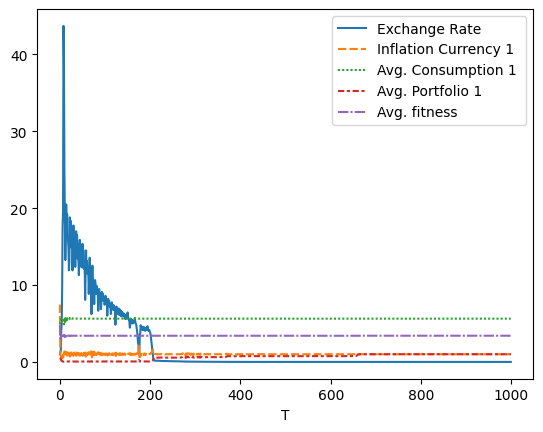

In [61]:
model_df_1 = pd.DataFrame.from_dict(model_1.datacollector).set_index('T').fillna(0)
seaborn.lineplot(model_df_1)

## 改變參數
在 Arifovic (2001) 中，作者除了比較 $G_1, G_2 = 0, 9$ 之外，另外比較了 $G_1, G_2 = 0, 1.5$ 的參數，並得出結論，收斂至均衡速度較慢

模型則只需要改一個參數

In [62]:
model_2 = CurrencySubstitutionModel(
            genetic_algo_class  =   ga, 
            n_agents            =   300,
            G_1                 =   0,
            G_2                 =   1.5,
            endowment_1         =   10,
            endowment_2         =   1,
            scheduler_constructor =   abm_schedular)

In [63]:

for _ in tqdm(range(1000)):
    model_2.step() 


100%|██████████| 1000/1000 [00:16<00:00, 61.10it/s]


<AxesSubplot: xlabel='T'>

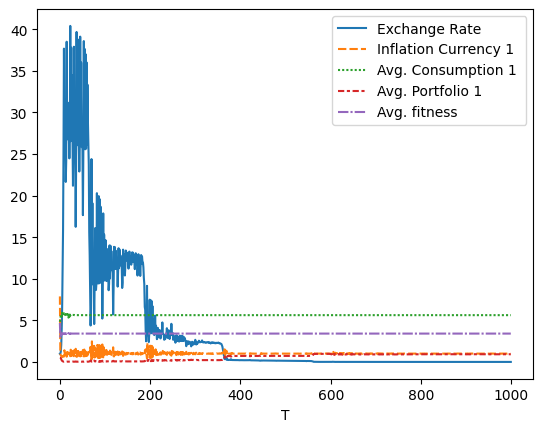

In [64]:

model_df_2 = pd.DataFrame.from_dict(model_2.datacollector).set_index('T').fillna(0)
seaborn.lineplot(model_df_2)

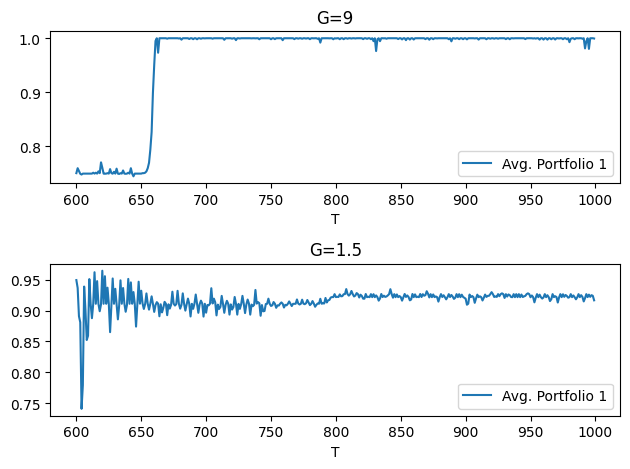

In [67]:
from matplotlib import pyplot as plt


avg_fraction_1 = model_df_1[['Avg. Portfolio 1']]
avg_fraction_2 = model_df_2[['Avg. Portfolio 1']]

fig, axs = plt.subplots(2,1)

axs[0].set_title('G=9')
axs[1].set_title('G=1.5')
seaborn.lineplot(avg_fraction_1[600:], ax=axs[0])
seaborn.lineplot(avg_fraction_2[600:], ax=axs[1])
fig.tight_layout()

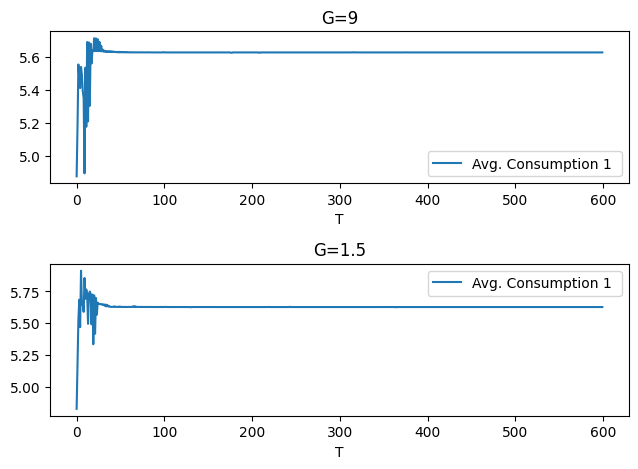

In [68]:
avg_consumption_1 = model_df_1[['Avg. Consumption 1 ']]
avg_consumption_2 = model_df_2[['Avg. Consumption 1 ']]


fig, axs = plt.subplots(2,1)
axs[0].set_title('G=9')
axs[1].set_title('G=1.5')
seaborn.lineplot(avg_consumption_1[:600], ax=axs[0])
seaborn.lineplot(avg_consumption_2[:600], ax=axs[1])
fig.tight_layout()